In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Train Data

In [252]:
X_station_train = pd.read_csv('./Train/Train/X_station_train.csv')
X_station_train['date'] = pd.to_datetime(X_station_train['date'])
baseline_forecast_train = pd.read_csv('./Train/Train/Baselines/Baseline_forecast_train.csv')
baseline_observation_train = pd.read_csv('./Train/Train/Baselines/Baseline_observation_train.csv')
station_coords = pd.read_csv('./Other/Other/stations_coordinates.csv')
Y_train = pd.read_csv('./Train/Train/Y_train.csv')

In [253]:
X_station_train["month"] = X_station_train["date"].dt.month
X_station_train["Id_split"] = X_station_train["Id"].str.split("_")
X_station_train["hour"] = X_station_train["Id_split"].apply(lambda s: s[-1]).astype(int)
X_station_train["Id"] = X_station_train["Id_split"].apply(lambda s: s[:2]).str.join("_")
X_station_train = X_station_train.drop(columns="Id_split")

# Scale Data

In [254]:
scale_cols = ["ff", "t", "td", "hu", "dd", "precip", "lat", "lon", "height_sta"]
X_station_train

,number_sta,date,ff,t,td,hu,dd,precip,Id,month,hour
0,14066001,2016-01-01 00:00:00,3.05,279.28,277.97,91.4,200.0,0.0,14066001_0,1,0
1,14066001,2016-01-01 01:00:00,2.57,278.76,277.45,91.4,190.0,0.0,14066001_0,1,1
2,14066001,2016-01-01 02:00:00,2.26,278.27,277.02,91.7,181.0,0.0,14066001_0,1,2
3,14066001,2016-01-01 03:00:00,2.62,277.98,276.95,93.0,159.0,0.0,14066001_0,1,3
4,14066001,2016-01-01 04:00:00,2.99,277.32,276.72,95.9,171.0,0.0,14066001_0,1,4
...,...,...,...,...,...,...,...,...,...,...,...
4409469,95690001,2017-12-30 19:00:00,9.10,286.68,283.44,80.8,239.0,0.0,95690001_729,12,19
4409470,95690001,2017-12-30 20:00:00,8.58,286.39,283.21,81.1,231.0,0.0,95690001_729,12,20
4409471,95690001,2017-12-30 21:00:00,8.74,286.28,283.40,82.6,226.0,0.0,95690001_729,12,21
4409472,95690001,2017-12-30 22:00:00,9.04,286.21,283.29,82.4,224.0,0.0,95690001_729,12,22


In [255]:
df = Y_train[["Id", "Ground_truth"]].dropna()
for hour in range(24):
    print(hour)
    X_subset = X_station_train.loc[X_station_train["hour"]==hour, ["Id", "ff","t","td","hu","dd","precip"]] #.add_suffix(f"_{hour}")
    # X_subset = X_subset.rename(columns={f"Id_{hour}":"Id"})
    # print(X_subset.shape)
    df = pd.merge(df, X_subset, on="Id", how="left", suffixes=["", f"_{hour}"])

df = df.rename(columns=dict(ff="ff_0", t="t_0", td="td_0", hu="hu_0", dd="dd_0", precip="precip_0"))
df = pd.merge(df, X_station_train[["Id", "month"]].groupby("Id").first().reset_index(), on="Id", how="left")
df = pd.merge(df, baseline_observation_train[["Id", "Prediction"]].rename(columns=dict(Prediction="pred_obs")), on="Id", how="left")
df = pd.merge(df, baseline_forecast_train[["Id", "Prediction"]].rename(columns=dict(Prediction="pred_fore")), on="Id", how="left")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [256]:
df["number_sta"] = df["Id"].str.split("_").apply(lambda s: s[0]).astype("int64")
df = pd.merge(df, station_coords, on="number_sta", how="left")
df = df.drop(columns="number_sta")

In [277]:
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

In [275]:
from scipy.io import netcdf
with netcdf.NetCDFFile('./Other/Other/NW_masks.nc', 'r') as f:
    print(f)
    # nw_masks = f.variables[va]

TypeError: Error: ./Other/Other/NW_masks.nc is not a valid NetCDF 3 file

In [257]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Id","Ground_truth"])
y = df["Ground_truth"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [258]:
def MAPE(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true+1)))

In [166]:
from xgboost import XGBRegressor

xgb2 = XGBRegressor(
    n_estimators = 1200,
    max_depth = 7,
    learning_rate = 0.1,
    objective = "reg:squaredlogerror",
    n_jobs=-1,
    verbosity=1
)

In [ ]:
xgb2.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)

In [265]:
from xgboost import XGBRegressor

xgb_gpu = XGBRegressor(
    objective = "reg:squaredlogerror",
    tree_method = 'gpu_hist', 
    n_estimators = 3000,
    max_depth = 9,
    max_bin = 512,
    learning_rate = 0.1,
    colsample_bytree = 0.8,
    gpu_id = 0,
    verbosity=1
)

In [266]:
xgb_gpu.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=200)

[0]	validation_0-rmsle:0.82528
[1]	validation_0-rmsle:0.79921
[2]	validation_0-rmsle:0.78790
[3]	validation_0-rmsle:0.76466
[4]	validation_0-rmsle:0.74316
[5]	validation_0-rmsle:0.72306
[6]	validation_0-rmsle:0.70405
[7]	validation_0-rmsle:0.69661
[8]	validation_0-rmsle:0.67907
[9]	validation_0-rmsle:0.67275
[10]	validation_0-rmsle:0.65647
[11]	validation_0-rmsle:0.64114
[12]	validation_0-rmsle:0.62693
[13]	validation_0-rmsle:0.61350
[14]	validation_0-rmsle:0.60094
[15]	validation_0-rmsle:0.59761
[16]	validation_0-rmsle:0.58584
[17]	validation_0-rmsle:0.57498
[18]	validation_0-rmsle:0.56466
[19]	validation_0-rmsle:0.55529
[20]	validation_0-rmsle:0.55332
[21]	validation_0-rmsle:0.54469
[22]	validation_0-rmsle:0.54274
[23]	validation_0-rmsle:0.53474
[24]	validation_0-rmsle:0.52740
[25]	validation_0-rmsle:0.52605
[26]	validation_0-rmsle:0.51916
[27]	validation_0-rmsle:0.51315
[28]	validation_0-rmsle:0.50720
[29]	validation_0-rmsle:0.50636
[30]	validation_0-rmsle:0.50122
[31]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=512,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=12,
             num_parallel_tree=1, objective='reg:squaredlogerror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=1)

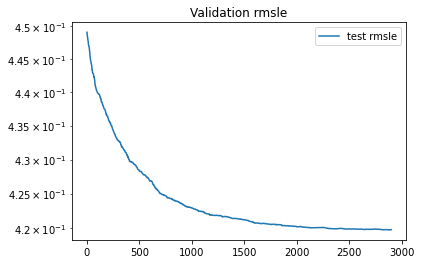

In [267]:
evals_result = xgb_gpu.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmsle'][100:], label='test rmsle')
plt.title('Validation rmsle')
plt.legend()
plt.show()

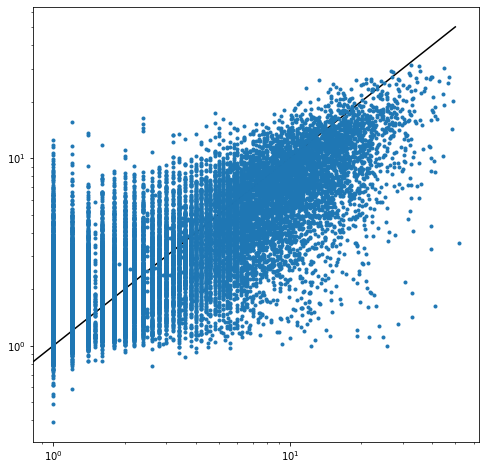

30.47570421140119


In [268]:
y_pred = xgb_gpu.predict(X_test)

plt.figure(figsize=(8,8))
plt.plot((0,50), (0,50), "k")
# plt.plot(y_test, y_pred, ".")
plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

print(MAPE(y_test, y_pred)) # previous best: 27.9057

In [251]:
y_pred = xgb2.predict(X_test)

plt.figure(figsize=(8,8))
plt.plot((0,50), (0,50), "k")
# plt.plot(y_test, y_pred, ".")
plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

print(MAPE(y_test, y_pred)) # previous best: 28.0478

ValueError: Feature shape mismatch, expected: 150, got 161

# Train Data

# Test Data

In [157]:
X_station_test = pd.read_csv('./Test/Test/X_station_test.csv')
baseline_forecast_test = pd.read_csv('./Test/Test/Baselines/Baseline_forecast_test.csv')
baseline_observation_test = pd.read_csv('./Test/Test/Baselines/Baseline_observation_test.csv')

In [158]:
X_station_test["hour"] = X_station_test["Id"].str.split("_").apply(lambda s: s[-1]).astype(int)
X_station_test["Id"] = X_station_test["Id"].str.split("_").apply(lambda s: s[:2]).str.join("_")

In [160]:
baseline_obs = baseline_observation_test[["Id", "Prediction"]].rename(columns=dict(Prediction="pred_obs"))
baseline_fore = baseline_forecast_test[["Id", "Prediction"]].rename(columns=dict(Prediction="pred_fore"))
df_test = pd.merge(baseline_obs, baseline_fore, on="Id", how="left")

for hour in tqdm(range(24)):
    X_subset = X_station_test.loc[X_station_test["hour"]==hour, ["Id", "ff","t","td","hu","dd","precip"]] #.add_suffix(f"_{hour}")
    # X_subset = X_subset.rename(columns={f"Id_{hour}":"Id"})
    # print(X_subset.shape)
    df_test = pd.merge(df_test, X_subset, on="Id", how="left", suffixes=["", f"_{hour}"])

df_test = df_test.rename(columns=dict(ff="ff_0", t="t_0", td="td_0", hu="hu_0", dd="dd_0", precip="precip_0"))
df_test = pd.merge(df_test, X_station_test[["Id", "month"]].groupby("Id").first().reset_index(), on="Id", how="left")

100%|██████████| 24/24 [00:02<00:00,  8.12it/s]


In [161]:
df_test["number_sta"] = df_test["Id"].str.split("_").apply(lambda s: s[0]).astype("int64")
df_test = pd.merge(df_test, station_coords, on="number_sta", how="left")
df_test = df_test.drop(columns="number_sta")

In [119]:
cols = df_test.columns.tolist()
cols = cols[0:1] + cols[3:] + cols[1:3]
df_test = df_test[cols]

In [164]:
X_eval = df_test[X_train.columns]
xgb_prediction = xgb.predict(X_eval)

In [165]:
submission_df = pd.DataFrame(dict(
    Id = df_test["Id"],
    Prediction = xgb_prediction+1
))

In [234]:
submission_df.to_csv("Submissions/submission_0.csv", index=False)